In [ ]:
# !pip install --upgrade pip
# !pip install opencv-python matplotlib pytesseract numpy
# !sudo apt-get update
# !sudo apt-get install ffmpeg libsm6 libxext6  -y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pytesseract
import numpy as np

#### Read Image

In [ ]:
img_path = r"/content/drive/MyDrive/test_img/1.jpg"

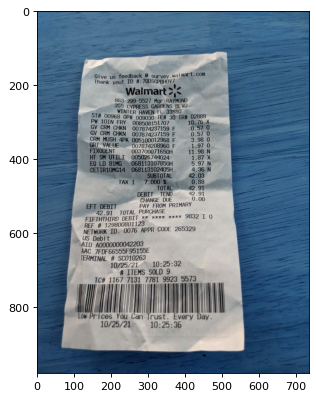

In [ ]:
img = cv2.imread(img_path)

figure(figsize=(10, 6), dpi=80)
plt.imshow(img)

#### Tesseract OCR

In [ ]:
# output_img = img.copy()
# data = pytesseract.image_to_data(img,output_type = 'dict')
# n_data = len(data['text'])
# for i in range(n_data):
#     if data['conf'][i] > 40 and len(data['text'][i])>3:
#         print(data['text'][i])

#### By Contour & Edge Detection

In [ ]:
# get image dimensions
img_height,img_width,channel = img.shape
img_center = (img_width//2, img_height//2) 
print("Image shape : ",img.shape)

# resize
if img_height > 1024 and img_width > 768:
  img = cv2.resize(img, None, fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC)
  plt.figure()
  plt.imshow(img)

Image shape :  (981, 736, 3)


In [ ]:
def remove_text(input_img, iterations=3):
    '''Repeated Closing operation to remove text from the document'''  
    kernel = np.ones((5,5),np.uint8)
    output_img = cv2.morphologyEx(input_img, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return output_img

def remove_background(input_img):
    '''remove background using GrabCut'''
    mask = np.zeros(input_img.shape[:2], np.uint8)

    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    rect = (20, 20, input_img.shape[1]-20, input_img.shape[0]-20)

    cv2.grabCut(input_img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    output_img = input_img*mask2[:,:,np.newaxis]

    return output_img

def detect_contour(input_img, keep_contours=3, select_contour=0):
    # Blank canvas
    img_base = np.zeros_like(input_img)

    # Finding contours for the detected edges.
    # contours, hierarchy = cv2.findContours(input_img, cv2.RETR_LIST, cv.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(input_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Keep only the largest detected contours
    largest_con = sorted(contours, key=cv2.contourArea, reverse=True)[:keep_contours]
    output_img = cv2.drawContours(img_base, largest_con, select_contour, (255, 255, 255), 3)
    
    return (contours, largest_con, output_img)

def get_corners(input_img, largest_contours):
    # Blank canvas.
    img_base = np.zeros_like(input_img)
    
    # Loop over the contours.
    for c in largest_contours:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        if len(corners) == 4: # if a rectangle is found, take its c (contour)
            break
        
    output_img = cv2.drawContours(img_base, c, -1, (255, 255, 255), 3) # draw rectangle contour on base image
    output_img = cv2.drawContours(output_img, corners, -1, (255, 0, 255), 15) # draw corner points on base image
    return (corners, output_img)

def order_corner_points(corners):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    corners = np.array(corners)
    s = corners.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[1] = corners[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[3] = corners[np.argmax(s)]
 
    diff = np.diff(corners, axis=1)
    # Top-right point will have the smallest difference.
    rect[0] = corners[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[2] = corners[np.argmax(diff)]
    # Return the ordered coordinates
    return rect.astype('int').tolist()  # return [tr, tl, bl, br]

def get_destination_coordinates(corners_ordered):
    # input corners must be ordered this way (tr, tl, bl, br)

    (tr, tl, bl, br) = corners_ordered

    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    # heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    # heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    heightA = np.sqrt(((tr[1] - br[1]) ** 2) + ((tr[0] - br[0]) ** 2))
    heightB = np.sqrt(((tl[1] - bl[1]) ** 2) + ((tl[0] - bl[0]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Final destination co-ordinates.
    # destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
    destination_corners = [[maxWidth, 0], [0, 0], [0, maxHeight], [maxWidth, maxHeight]] # tr, tl, bl, br

    return (destination_corners, maxWidth, maxHeight)

def show_img(input_img):
    plt.figure(dpi=100)
    plt.imshow(input_img)

In [ ]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# img_histeql = cv2.equalizeHist(img_gray)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_histeql = clahe.apply(img_gray)

# img_blur = cv2.bilateralFilter(img_gray, 100, 25, 25)  # 100, 25, 25
img_blur = cv2.medianBlur(img_gray, 3)

img_edges = cv2.Canny(img_blur, 0, 20)
# img_edges = cv2.dilate(img_edges, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

# # other filters
# # img_noalpha = cv2.cvtColor(img_histeql, cv2.COLOR_RGBA2RGB)
# # img_removebg = remove_background(img_noalpha)
# # img_notext = remove_text(img_blur, iterations=3)
# # img_binary = cv2.threshold(img_notext, 10, 255, cv2.THRESH_BINARY)[1]

contours, largest_contours, img_contour = detect_contour(img_edges, keep_contours=3, select_contour=0)
corners, img_corners = get_corners(img_contour, largest_contours)

# # corners  # tr, tl, bl, br
corners_ordered = order_corner_points(np.concatenate(corners)) # tr, tl, bl, br
destination_corners, maxWidth, maxHeight = get_destination_coordinates(corners_ordered)

# # transform perspective
M = cv2.getPerspectiveTransform(np.float32(corners_ordered), np.float32(destination_corners)) # Getting the homography
# Perspective transform using homography
img_final = cv2.warpPerspective(img, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

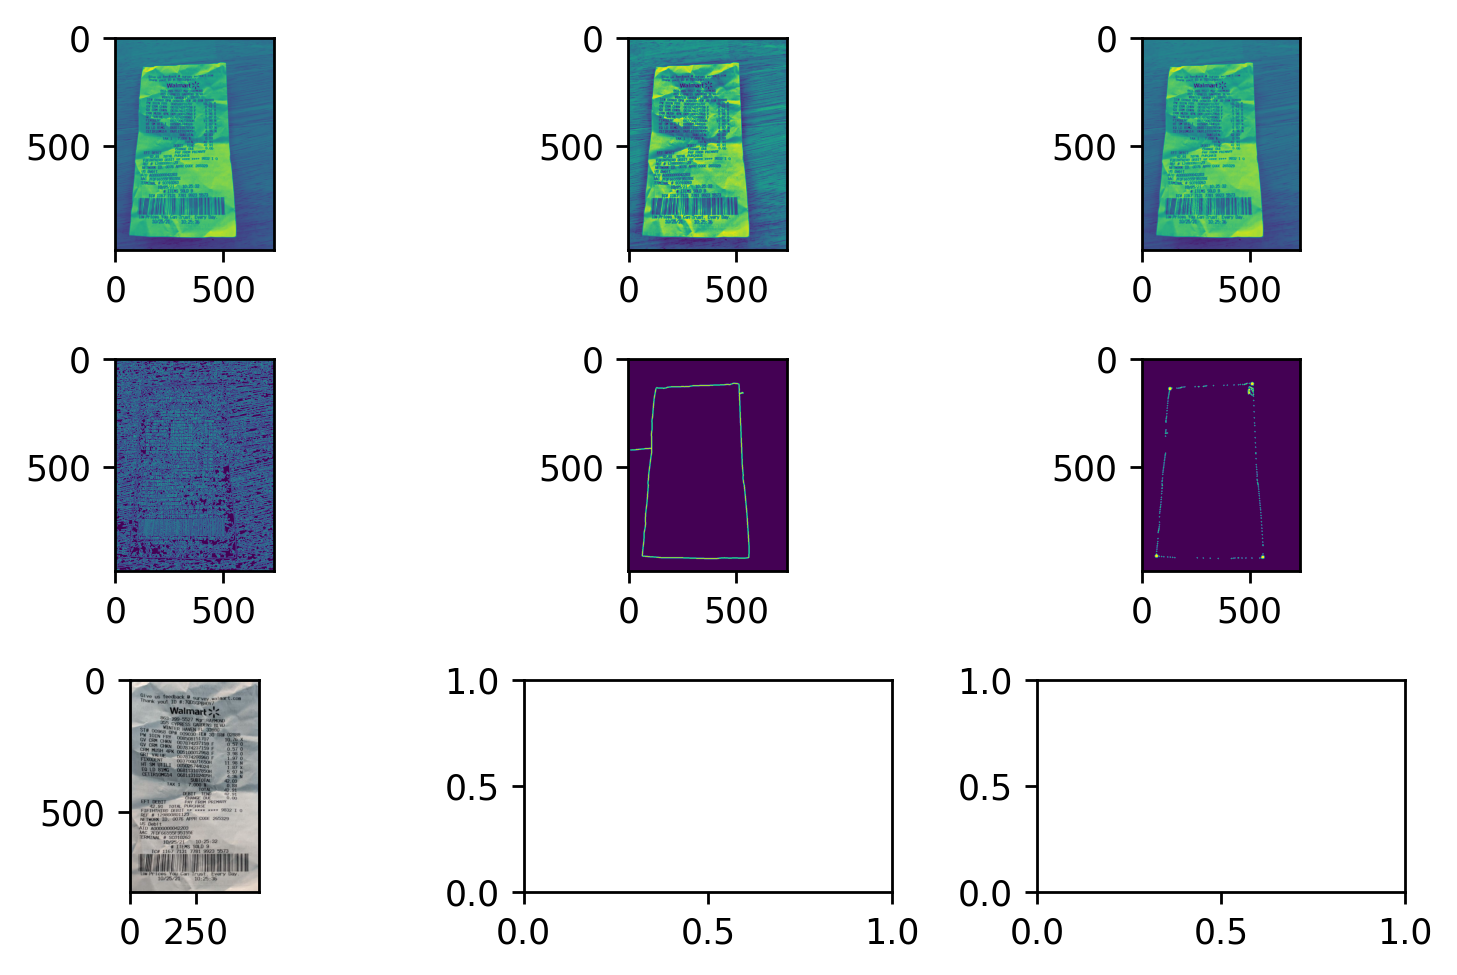

In [ ]:
fig, axes = plt.subplots(3,3, dpi=250)
axes[0][0].imshow(img_gray)
axes[0][1].imshow(img_histeql)
axes[0][2].imshow(img_blur)
axes[1][0].imshow(img_edges)
axes[1][1].imshow(img_contour)
axes[1][2].imshow(img_corners)
axes[2][0].imshow(img_final)
plt.tight_layout()

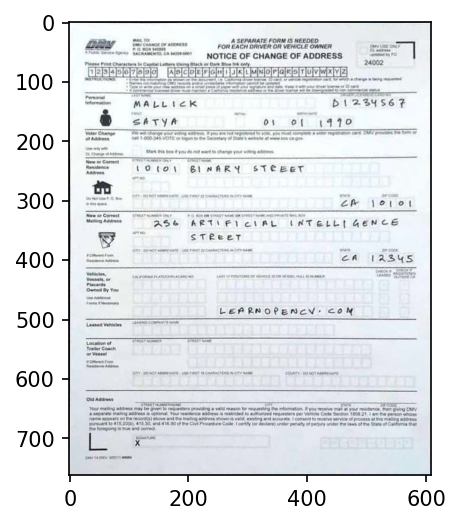

In [ ]:
figure(dpi=150)
plt.imshow(img_final)

In [ ]:
# # Displaying the corners.
# for index, c in enumerate(corners):
#   character = chr(65 + index)
#   cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

#### Detect Rotation by Using Minimal Area Rectangles

In [ ]:
# grab the (x, y) coordinates of all pixel values that
# are greater than zero, then use these coordinates to
# compute a rotated bounding box that contains all
# coordinates
coords = np.column_stack(np.where(img_edges > 0))
angle = cv2.minAreaRect(coords)[-1]
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
	angle = -(90 + angle)
# otherwise, just take the inverse of the angle to make
# it positive
else:
	angle = -angle

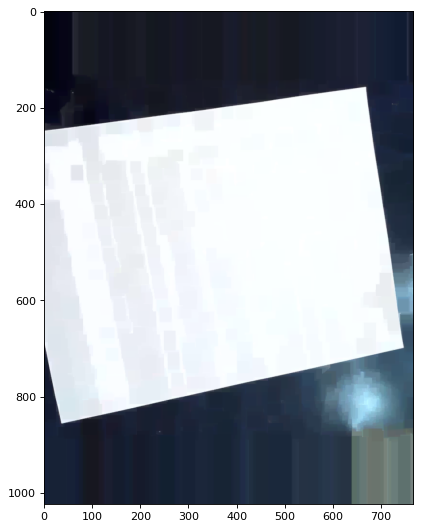

In [ ]:
M = cv2.getRotationMatrix2D(img_center, angle, 1.0)
img_rotated = cv2.warpAffine(img, M, (img_width, img_height),
	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

figure(figsize=(10,8),dpi=80)
plt.imshow(img_rotated)

#### Detect Lines

In [ ]:
import math

#lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 230  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(img_edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

print("No of lines : ",len(lines))

actual_lines = []
actual_points =[]
y_distance = 20

for line in lines:
    for x1,y1,x2,y2 in line:
        if len(actual_lines) == 0:
            actual_lines.append(y1)
            actual_points.append([x1,y1,x2,y2])
           
        else:
            is_needAdd =True
            for actual_y in actual_lines:
                if(np.abs(actual_y-y1) < y_distance):
                    is_needAdd = False
                    break
            
            if is_needAdd:
                actual_lines.append(y1)   
                actual_points.append([x1,y1,x2,y2])

print(actual_lines)

No of lines :  8
[81, 27]


[[49, 81, 332, 26], [332, 27, 361, 266]]


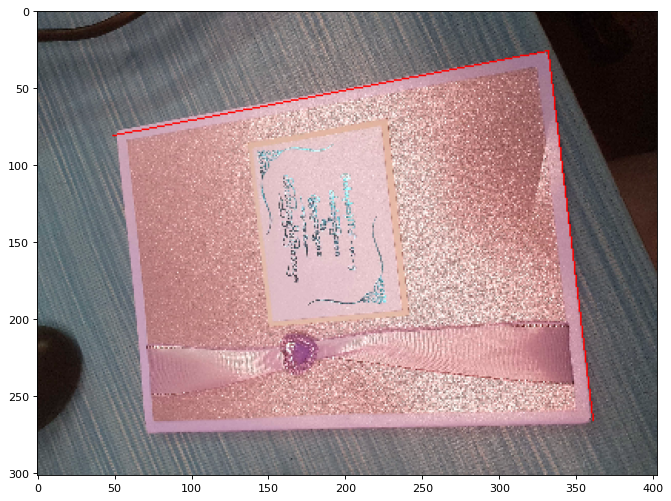

In [ ]:
img_output = img_resized.copy()
print(actual_points)
for x1,y1,x2,y2 in actual_points:
    cv2.line(img_output,(x1,y1),(x2,y2),(255,0,0),1)
figure(figsize=(10,8),dpi=80)
plt.imshow(img_output)

#### Get Rotation Degree from Line Coordinates & Rotate

In [ ]:
# actual_lines = []
# for i in lines:
#     actual_lines.append(i[0])

# #rotate the image with given theta value
# def rotate(img, theta):
#     rows, cols = img.shape[0], img.shape[1]
#     image_center = (cols/2, rows/2)
    
#     M = cv2.getRotationMatrix2D(image_center,theta,1)

#     abs_cos = abs(M[0,0])
#     abs_sin = abs(M[0,1])

#     bound_w = int(rows * abs_sin + cols * abs_cos)
#     bound_h = int(rows * abs_cos + cols * abs_sin)

#     M[0, 2] += bound_w/2 - image_center[0]
#     M[1, 2] += bound_h/2 - image_center[1]

#     # rotate orignal image to show transformation
#     rotated = cv2.warpAffine(img,M,(bound_w,bound_h),borderValue=(255,255,255))
#     return rotated

# # get rotation
# dy = actual_lines[0][1] - actual_lines[0][3]
# dx = actual_lines[0][0] - actual_lines[0][2]
# degree_to_rotate = math.degrees(np.pi - math.atan2(dy, dx))
# degree_to_rotate
# rotated_img = rotate(edges, degree_to_rotate)
# figure(figsize=(10,8),dpi=80)
# plt.imshow(rotated_img)

In [ ]:
img_output = img.copy()
print(actual_points)
for x1,y1,x2,y2 in actual_points:
    cv2.line(img_output,(x1,y1),(x2,y2),(255,0,0),1)
figure(figsize=(10,8),dpi=80)
plt.imshow(img_output)

### Cut Image to Parts

(125, 241, 3)


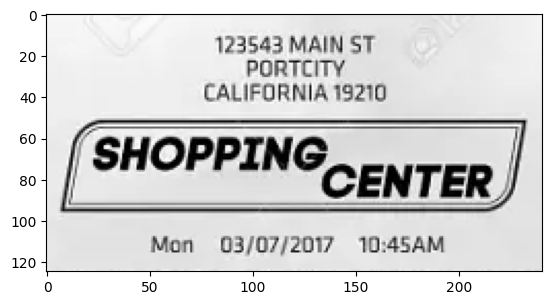

In [ ]:
fist_part = actual_points[2]
first_img = img[:fist_part[3],fist_part[0]:fist_part[2],:]
print(first_img.shape)
plt.imshow(first_img)

[18, 203, 259, 203]
(78, 241, 3)


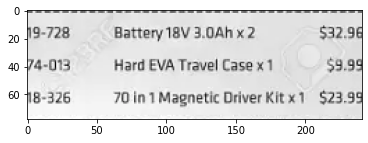

In [ ]:
second_part = actual_points[1]
print(second_part)
second_img = img[fist_part[3]:second_part[3],second_part[0]:second_part[2],:]
print(second_img.shape)
plt.imshow(second_img)

203
315


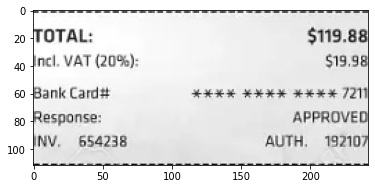

In [ ]:
third_part = actual_points[0]

print(second_part[3])
print(third_part[3])


third_img = img[second_part[3]:third_part[3],third_part[0]:third_part[2],:]
plt.imshow(third_img)

[18, 315, 260, 315]
(140, 242, 3)


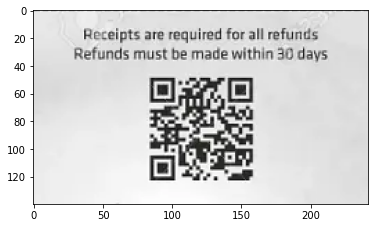

In [ ]:
third_part = actual_points[0]
img_height,img_width,channel = img.shape
print(third_part)
final_img = img[third_part[3]:,third_part[0]:third_part[2],:]
print(final_img.shape)
plt.imshow(final_img)